# Tries

### Die Hilfsklasse Alphabet

Auch hier benötigen wir wieder die Hilfsklasse Alphabet, die wir schon im Notebook zum Thema Stringsortierung kennengelernt haben. 

In [1]:
class Alphabet:
    
    def __init__(self, chars):
        self._inverse = [None]*len(chars)
        
        self._alphabet=dict()
        for (i, c) in enumerate(chars):
            self._alphabet[c] = i
            self._inverse[i] = c
    
    def toChar(self, index):
        return self._inverse[index]
        
    def toIndex(self, char):
        return self._alphabet[char]
    
    def contains(self, char):
        return self._alphabet.contains(char)
        
    def radix(self):
        return len(self._inverse)
    
lowercase = Alphabet("abcdefghijklmnopqrstuvwxyz")
uppercase = Alphabet("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
ascii = Alphabet([chr(i) for i in range(0, 128)])
extendedAscii = Alphabet([chr(i) for i in range(0, 256)])
DNA = Alphabet("ACGT")    

## Tries

Die folgende Klasse implementiert die wichtigen Operationen zum einfügen / löschen und suchen in einem Trie.

In [2]:
class Trie:
    
    class Node:
        def __init__(self,rChildren):           
            self.value = None
            self.children = [None] * rChildren
    
    def __init__(self, alphabet):
        self._alphabet = alphabet
        self._root = Trie.Node(alphabet.radix())
    
    def get(self, key):
        x = self._get(self._root, key, 0)
        if x == None:
            return None
        else:
            return x.value
    
    def _get(self, node, key, d):
        if (node == None):
            return None
        if d == len(key):
            return node
        c = self._alphabet.toIndex(key[d])
        return self._get(node.children[c], key, d + 1)
            
    def put(self, key, value):
        self._root = self._put(self._root, key, value, 0)
        
    def _put(self, node, key, value, d):
        if node == None:
            node = Trie.Node(self._alphabet.radix())
        if d == len(key):
            node.value = value
            return node        
        c = self._alphabet.toIndex(key[d])
        node.children[c] = self._put(node.children[c], key, value, d + 1)
        return node
        
        
    def delete(self, key):
        self._root = self._delete(self._root, key, 0)
    
    def _delete(self, node, key, d):
        if node == None:
            return None
        if d == len(key):
            node.value = None
        else:
            c = self._alphabet.toIndex(key[d])
            node.children[c] = self._delete(node.children[c], key, d + 1)
        
        if node.value != None:
            return node
        
        nonNullChildren = [c for c in node.children if c != None]
        if len(nonNullChildren) > 0:
            return node
        else:
            return None
        
    def height(self):
        return self._height(self._root)
    
    def _height(self, node):
        if node == None:
            return -1
        return 1 + max([self._height(child) for child in node.children])
        

### Visualisierung

Der nachfolgende Code dient zur Visualisierung eines Tries. Die Details sind für das Verständnis nicht wichtig und können beim lernen übersprungen werden. 

In [3]:
from graphviz import Graph
def plotTrie(trie):
    dot = Graph(comment='Tree')
    _plotTrie(trie._root, None, ' ', trie._alphabet, dot)
    display(dot)

def _plotTrie(node, parent, char, alphabet, dot):                         
    
    if node == None:        
        return 

    if node.value != None:
        dot.node(str(node), str(char) +":" +str(node.value))
    else:
        dot.node(str(node), str(char))
    
    if parent != None:
        dot.edge(str(parent), str(node))    
    
    labeledChildren = [(alphabet.toChar(p), child) for (p, child) 
                       in enumerate(node.children) if child != None]        
    for (n, (charChild, child)) in enumerate(labeledChildren):                  
        _plotTrie(child, node, charChild, alphabet, dot)      


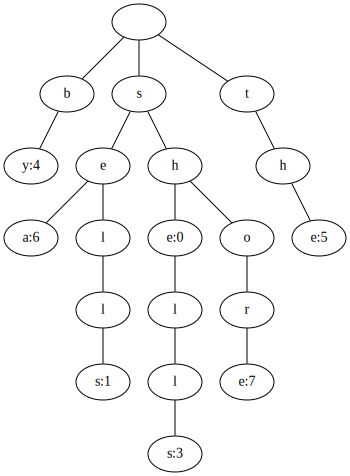

In [4]:
t = Trie(lowercase)
for (value, key) in enumerate(["she", "sells", "sea", "shells", "by", "the", "sea", "shore"]):
    t.put(key, value)
plotTrie(t)



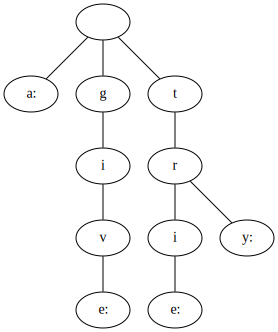

In [5]:
t = Trie(lowercase)
for (value, key) in zip(['']*5, ["give", "a", "trie", "a", "try"]):
    t.put(key, value)
plotTrie(t)


### Experimente

Ausgestattet mit einer Funktion um Tries zu visualisieren, können wir nun mit Tries experimentieren. 

Als erstes schauen wir uns die Sequenz von Tries an, die entstehtn wenn wir die Schlüssel she, sells, sea, shells und by einfügen. 

inserted  she


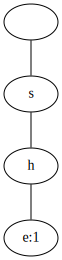

inserted  sells


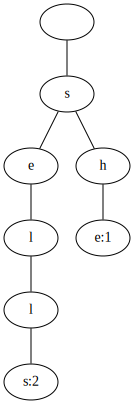

inserted  sea


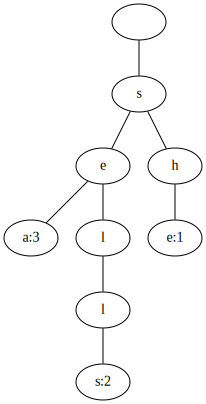

inserted  shells


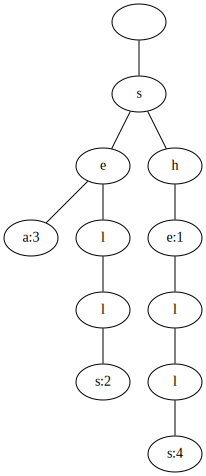

inserted  by


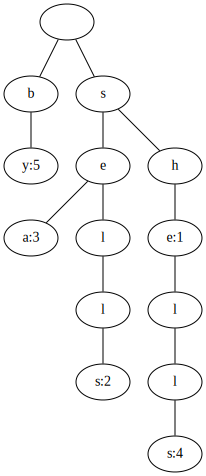

In [6]:
t = Trie(lowercase)
for (key, value) in [("she",1), ("sells", 2), ("sea", 3), ("shells", 4), ("by", 5)]:
    t.put(key, value)
    print("inserted ", key)
    plotTrie(t)


Als nächstes löschen wir wieder einige Schlüssel.

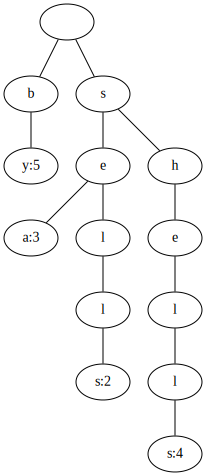

In [7]:
t.delete("she")
plotTrie(t)

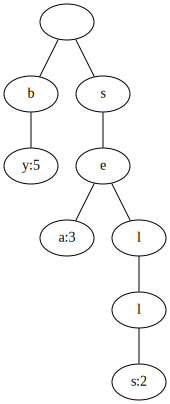

In [8]:
t.delete("shells")
plotTrie(t)

## Zeichenbasierte Operationen

Nun erweitern wir den Trie um zeichenbasierte Operationen.

In [9]:
class TrieST(Trie):
    
    def __init__(self, alphabet):
        super().__init__(alphabet)
    
    def keys(self):
        return self.keysWithPrefix("")
    
    def keysWithPrefix(self, prefix):
        queue = []
        self._collect(self._get(self._root, prefix, 0), prefix, queue)
        return queue

    def _collect(self, node, prefix, queue):
        if node == None:
            return
        if node.value != None:
            queue.append(prefix)
        labeledChildren  = [(self._alphabet.toChar(p), child) 
                            for (p, child) in enumerate(node.children) if child != None]
        for (char, child) in labeledChildren:
            self._collect(child, prefix + char, queue)

    
    def longestPrefixOf(self, s):
        l = self._search(self._root, s, 0, 0)
        return s[0:l]
    
                
    def _search(self, node, s, d, length):
        print(s, d)
        if node == None: 
            return length
        if node.value != None:
            length = d
        if d == len(s):
            return length
        c = self._alphabet.toIndex(s[d])
        return self._search(node.children[c], s, d+1, length)
    
    def keysThatMatch(self, pattern):
        queue = []
        self._collectWithWildcard(self._root, "", pattern, queue)
        return queue
    
    def _collectWithWildcard(self, node, prefix, pattern, queue):
        
        if node == None:
            return
       
        d = len(prefix)

        if d == len(pattern) and node.value != None:
            queue.append(prefix)
        
        if d == len(pattern):
            return 
        
        next = pattern[d]; 
        
        labeledChildren  = [(self._alphabet.toChar(p), child) 
                            for (p, child) in enumerate(node.children) 
                            if child != None and (self._alphabet.toChar(p) == next or next == '.')]
        
        for (char, child) in labeledChildren:
            self._collectWithWildcard(child, prefix + char, pattern, queue)

Wir bauen uns wieder einen Trie auf und testen unsere neu implementierten Methoden. 

In [10]:
t = TrieST(lowercase)
t.put("she", 77)
t.put("sells", 88)
t.put("sea", 88)
t.put("shells", 88)
t.put("by", 88)


Als erstes geben wir alle Schlüssel aus:

In [11]:
for k in t.keys():
    print(k)

by
sea
sells
she
shells


Als nächstes suchen wir nach Schlüssel, die einem gewissen Muster entsprechen, also zum Beispiel mit s beginnen und 3 Zeichen lang sind.

In [12]:
for k in t.keysThatMatch("s.."):
    print(k)

sea
she


Wir können uns auch alle Schlüssel ausgeben lassen, die mit einem bestimmten Präfix anfangen.

In [13]:
for k in t.keysWithPrefix("sh"):
    print(k)
    

she
shells


Und zum Schluss experimentieren wir noch mit der Methode ```longestPrefixOf```.

In [14]:
print(t.longestPrefixOf("shegoesforalongwalk"))
print(t.longestPrefixOf("shellsort"))
print(t.longestPrefixOf("seagull"))

shegoesforalongwalk 0
shegoesforalongwalk 1
shegoesforalongwalk 2
shegoesforalongwalk 3
shegoesforalongwalk 4
she
shellsort 0
shellsort 1
shellsort 2
shellsort 3
shellsort 4
shellsort 5
shellsort 6
shellsort 7
shells
seagull 0
seagull 1
seagull 2
seagull 3
seagull 4
sea
